In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

data_path = '/content/drive/MyDrive/Thesis Dataset'

img_size = (224, 224)
batch_size = 32

In [ ]:
all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)



In [ ]:

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state= 29, stratify=train_labels
)
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


val_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:

model = Sequential()

model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))


model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


In [ ]:

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

train_accuracy = history.history['accuracy'][-1]
test_accuracy = model.evaluate(test_data_generator)[1]
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Epoch 1/10
23/23 [==============================] - 159s 6s/step - loss: 0.6982 - accuracy: 0.5435 - val_loss: 0.7138 - val_accuracy: 0.4500
Epoch 2/10
23/23 [==============================] - 148s 7s/step - loss: 0.6876 - accuracy: 0.5000 - val_loss: 0.6647 - val_accuracy: 0.5500
Epoch 3/10
23/23 [==============================] - 149s 6s/step - loss: 0.6084 - accuracy: 0.6728 - val_loss: 0.5053 - val_accuracy: 0.8250
Epoch 4/10
23/23 [==============================] - 146s 6s/step - loss: 0.4825 - accuracy: 0.7837 - val_loss: 0.5480 - val_accuracy: 0.7125
Epoch 5/10
23/23 [==============================] - 156s 7s/step - loss: 0.4495 - accuracy: 0.7978 - val_loss: 0.4424 - val_accuracy: 0.8250
Epoch 6/10
23/23 [==============================] - 147s 6s/step - loss: 0.3390 - accuracy: 0.8652 - val_loss: 0.3827 - val_accuracy: 0.8375
Epoch 7/10
23/23 [==============================] - 150s 7s/step - loss: 0.3593 - accuracy: 0.8469 - val_loss: 0.3395 - val_accuracy: 0.8625
Epoch 8/10
23

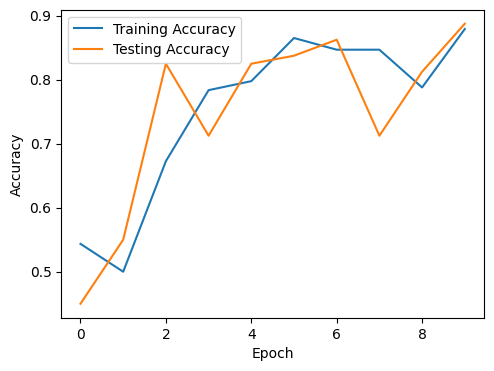

In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


7/7 [==============================] - 38s 5s/step


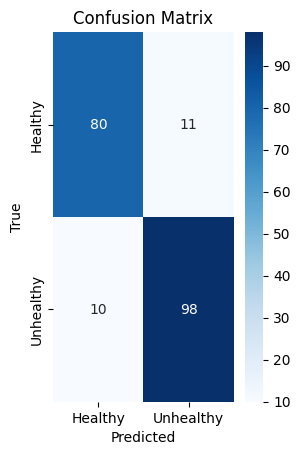


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.88      0.88        91
   Unhealthy       0.90      0.91      0.90       108

    accuracy                           0.89       199
   macro avg       0.89      0.89      0.89       199
weighted avg       0.89      0.89      0.89       199



In [ ]:

plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

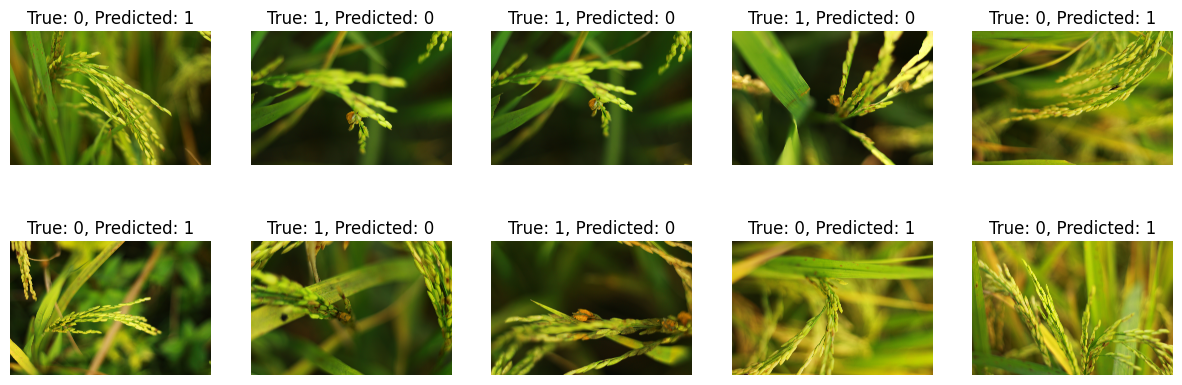

In [ ]:
import numpy as np
misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()


Using Preprocessing


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


data_path = '/content/drive/MyDrive/Thesis Dataset'
img_size = (224, 224)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

In [ ]:
train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=29, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

train_accuracy = history.history['accuracy'][-1]
test_accuracy = model.evaluate(test_data_generator)[1]
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Epoch 1/10
23/23 [==============================] - 319s 13s/step - loss: 0.6689 - accuracy: 0.5506 - val_loss: 0.6262 - val_accuracy: 0.5500
Epoch 2/10
23/23 [==============================] - 175s 8s/step - loss: 0.5675 - accuracy: 0.6770 - val_loss: 0.4552 - val_accuracy: 0.7375
Epoch 3/10
23/23 [==============================] - 167s 7s/step - loss: 0.4611 - accuracy: 0.7893 - val_loss: 0.2831 - val_accuracy: 0.9000
Epoch 4/10
23/23 [==============================] - 167s 7s/step - loss: 0.3983 - accuracy: 0.8399 - val_loss: 0.2280 - val_accuracy: 0.9375
Epoch 5/10
23/23 [==============================] - 163s 7s/step - loss: 0.3045 - accuracy: 0.8764 - val_loss: 0.2199 - val_accuracy: 0.9250
Epoch 6/10
23/23 [==============================] - 161s 7s/step - loss: 0.2849 - accuracy: 0.8820 - val_loss: 0.2259 - val_accuracy: 0.9125
Epoch 7/10
23/23 [==============================] - 168s 7s/step - loss: 0.2892 - accuracy: 0.8778 - val_loss: 0.1919 - val_accuracy: 0.9250
Epoch 8/10
2

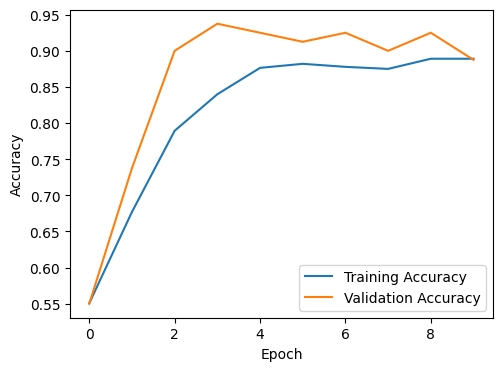

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



7/7 [==============================] - 38s 5s/step


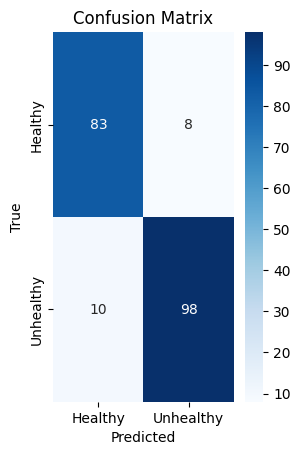


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.91      0.90        91
   Unhealthy       0.92      0.91      0.92       108

    accuracy                           0.91       199
   macro avg       0.91      0.91      0.91       199
weighted avg       0.91      0.91      0.91       199



In [ ]:
plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))


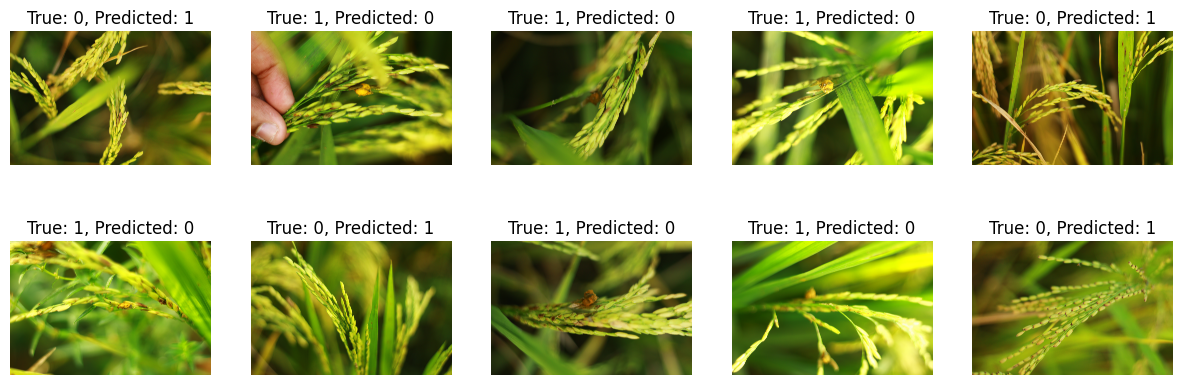

In [ ]:

misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()
